<a href="https://colab.research.google.com/github/shimamz71/9-TYPE-OF-CNN/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


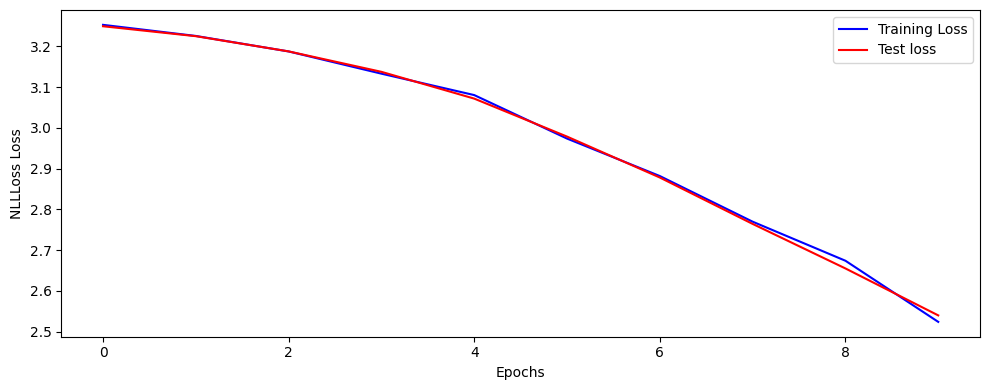

0.2980769230769231


In [ ]:
# Import the necessary libraries
import os
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader,TensorDataset # Import the DataLoader class
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

torch.manual_seed(2)
np.random.seed(2)


# Define the hyperparameters
batch_size = 32 # You can change this according to your GPU memory
num_epochs = 10 # You can change this according to your desired training time
learning_rate = 1e-4 # You can change this according to your optimization strategy

# Define the path to the folder containing the subfolders of images

folder_path = "/content/drive/MyDrive/Deep_Learning/Deep_learning/English_Alphabet"

# Define a list to store the image tensors
image_list = []
labels = []

# Define a function to extract the last part of a path
def extract_last_part(path):
    # Split the path by slashes
    parts = path.split("/")
    # Return the last part
    return int(parts[-1])

# Define a transform to convert images to grayscale and normalize them to [-1, 1]
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(), # [0,1]
    transforms.Normalize((0.5,), (0.5,))
])

# Loop through the subfolders in the folder
for subfolder in os.listdir(folder_path):
    # Get the full path of the subfolder
    subfolder_path = os.path.join(folder_path, subfolder)
    # Loop through the images in the subfolder
    for image_name in os.listdir(subfolder_path):
        # Get the full path of the image
        image_path = os.path.join(subfolder_path, image_name)
        # Open the image using PIL
        image = Image.open(image_path)
        # Apply the transform to the image
        image_tensor = transform(image)
        # Append the image tensor to the list
        image_list.append(image_tensor)

        #path = "/content/drive/MyDrive/Colab Notebooks/MLP/12"
        last_part = extract_last_part(subfolder_path)
        labels.append(last_part-1)

# Convert the list of image tensors to a single tensor, concatenates a sequence of tensors
image_tensor = torch.stack(image_list)

label_train = torch.tensor(labels, dtype=torch.float).view(len(labels),1) #520,1

# Reshape the image tensor from (520, 60, 60) to (520, 3600)
train_tensor = torch.reshape(image_tensor, (520, 3600))

# Print the shape and type of the image tensor
# print(image_tensor.shape)
# print(image_tensor.dtype)

# Create a copy of the image tensor
test_tensor = train_tensor.clone()
# Define the percentage of values to change
percentage = 0.60

# Loop through each row in the image tensor
for i in range(test_tensor.shape[0]):
    # Get the indices of the elements that are equal to -1 in the current row
    indices = torch.nonzero(test_tensor[i] == -1, as_tuple=False).squeeze()
    # Get the number of elements to change
    num_change = int(percentage * len(indices))

    # Get a random permutation of the indices
    perm = torch.randperm(len(indices))

    # Get the subset of indices to change
    subset = indices[perm[:num_change]]

    # Assign 1 to those indices
    test_tensor[i, subset] = 1


# Create data loaders for the new datasets
#  A generator object can be used as a keyword argument in many in-place random sampling functions, such as torch.rand, to control the randomness of the sampling
generator = torch.Generator()
generator.manual_seed(2) # control randomness
train_data = TensorDataset(train_tensor, label_train)
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          generator=generator,shuffle=True)
test_data = TensorDataset(test_tensor, label_train)
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size=520,
                                         generator=generator,shuffle=False)



# Define the MLP class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.fc5 = nn.Linear(hidden_sizes[3], output_size)
        self.dropout = nn.Dropout(.2)

    def forward(self, x):
        # Apply the activation functions
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc5(x), dim=-1) # Add logsoftmax in the last layer
        return x

# Create an instance of the MLP class
mlp = MLP(3600, [128, 64, 64, 32], 26)
# mlp = MLP(3600, [512, 512,256,128], 26)
# Print the model summary
# print(mlp)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)
def train_MLP(model, dataloader, criterion, optimizer, num_epochs, dataloader_test):
    test_loss = []
    train_loss = []
    # Loop over the number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        batch_train_loss = []
        model.train()
        for (data, label) in dataloader:
            # Zero out the gradients of the optimizer
            optimizer.zero_grad()
            # Forward pass the data
            y_predict = model(data) #32,26
            y_predict = y_predict.unsqueeze(-1) # 32,26,1
            label = label.long()

            loss_train = criterion(y_predict, label)
            batch_train_loss.append(loss_train.item())
            # Backward pass the loss and update the model parameters
            loss_train.backward()
            optimizer.step()
        train_loss.append(np.mean(batch_train_loss))
        model.eval()
        for data_test, label_test in dataloader_test:
            y_test_predict = model(data_test)
            y_test_predict = y_test_predict.unsqueeze(-1)
            label_test = label_test.long()
            loss_test = criterion(y_test_predict, label_test)
            test_loss.append(loss_test.item())

    fig = plt.figure(figsize=(10, 4))
    plt.plot(train_loss, label='Training Loss', c='b')
    plt.plot(test_loss, label='Test loss', c='r')
    plt.xlabel('Epochs')
    plt.ylabel('NLLLoss Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    for data, label in dataloader_test:
        with torch.no_grad():
            y_predict = model(data)
            y_predict = y_predict.numpy().reshape(y_predict.shape[0], 26)
            # class index
            y_predict = np.argmax(y_predict, axis=-1)
            y_predict = y_predict.reshape(y_predict.shape[-1], 1)
            label = label.numpy()
            acc = accuracy_score(label, y_predict)
            print(acc)
train_MLP(mlp, dataloader_train, criterion, optimizer, num_epochs,dataloader_test)



# tensor.long() is a method that converts a tensor to have the data type of torch.long, which is an alias for torch.int64.
# This means that the elements of the tensor will be 64-bit signed integers.

In [ ]:
# Import PyTorch library
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the MLP class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        # Define the layers using nn.Sequential
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(hidden_sizes[1], output_size),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        # Apply the layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Create an instance of the MLP class
mlp = MLP(3600, [128, 64], 26)

# Print the model summary
print(mlp)

MLP(
  (fc1): Sequential(
    (0): Linear(in_features=3600, out_features=128, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=64, out_features=26, bias=True)
    (1): LogSoftmax(dim=-1)
  )
)
